# Загрузка библиотек и датасетов

In [252]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import re 

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

In [253]:
RANDOM_SEED = 42 #для воспроизводимости результата 

data_train = pd.read_csv('main_task.xls')
data_test = pd.read_csv('kaggle_task.csv')
cities = pd.read_csv('worldcities.csv') #Датасет с данными о городах мира

data_train['sample'] = 1 # помечаем где у нас трейн
data_test['sample'] = 0 # помечаем где у нас тест
data_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = data_test.append(data_train, sort=False).reset_index(drop=True) # объединяем

countries = ['Russia', 'France', 'United Kingdom','Spain','Germany','Ukraine','Italy','Belarus', 'Romania', 'Austria', 'Poland', 
'Hungary','Netherlands', 'Serbia','Bulgaria', 'Czechia','Ireland','Denmark','Sweden','Croatia','Latvia', 'Norway', 'Moldova',
'Greece','Finland', 'Macedonia','Lithuania','Portugal', 'Estonia','Slovakia', 'Albania','Cyprus','Slovenia', 'Bosnia And Herzegovina',
'Kosovo','Belgium','Montenegro','Switzerland', 'Iceland','Luxembourg', 'Monaco','Liechtenstein','Malta','San Marino']
#Список стран Европы

In [254]:
cities = cities[cities.country.isin(countries)] 
cities = cities[['city', 'capital', 'population']]
cities.columns = ['City', 'Capital', 'Population'] 

data = data.merge(cities, on = 'City', how = 'left') #Добавляем в основной датасет 

In [255]:
data.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,Capital,Population
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,primary,11020000.0
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,primary,642045.0
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,NaN,488050.0
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,primary,10979000.0
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,primary,429564.0


In [256]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
 11  Capital            47374 non-null  object 
 12  Population         48119 non-null  float64
dtypes: float64(4), int64(1), object(8)
memory usage: 5.3+ MB


# Объявление функций

In [257]:
def date1(list): #Для извлечения дат из Review
    if len(list)==0:
        return np.nan
    else:
        return list[0]
    
def date2(list): #Для извлечения дат из Review
    if len(list)<=1:
        return np.nan
    else:
        return list[1]
    
def clean_name(str_val): #Обработка показателя по кухням Cuisine Style
    if pd.isna(str_val): 
        return ["Unknown"]
    str_val = str_val.strip('[]') 
    str_val = str_val.replace("\'",'') 
    str_val = str_val.split(", ") 
    return str_val

def get_price(str): #Для быстрого перевода показателя Price в числовой вид. 
    if str == '$$ - $$$':
        return 2
    if str == '$':
        return 1
    if str == '$$$$':
        return 3
    else:
        return 2

# Обработка данных, заполнение пропусков

## Number of Reviews

In [258]:
#Посмотрим на пропуски 
data[(pd.isna(data['Number of Reviews'])==True)]
#Видим, что даже при отсутствующих данных о количестве, в поле Reviews бывают отзывы. 
#В таком случае заменим пропуски средним значением, но перед этим отметим отсутствие отзывов отдельным признаком 

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,Capital,Population
7,id_7,Budapest,NaN,2330.0,NaN,NaN,"[[], []]",/Restaurant_Review-g274887-d8286886-Reviews-Be...,d8286886,0,0.0,primary,1752286.0
25,id_25,Madrid,NaN,5828.0,NaN,NaN,"[[], []]",/Restaurant_Review-g187514-d13202032-Reviews-W...,d13202032,0,0.0,primary,3266126.0
53,id_53,Prague,NaN,2095.0,NaN,NaN,"[[], []]",/Restaurant_Review-g274707-d7124128-Reviews-Ch...,d7124128,0,0.0,primary,1324277.0
74,id_74,Prague,"['Cafe', 'European', 'Czech']",2052.0,$,NaN,"[[""Nova' Doba""], ['01/26/2017']]",/Restaurant_Review-g274707-d12032989-Reviews-C...,d12032989,0,0.0,primary,1324277.0
81,id_81,Barcelona,"['Peruvian', 'South American']",4325.0,$$ - $$$,NaN,"[[], []]",/Restaurant_Review-g187497-d10088997-Reviews-N...,d10088997,0,0.0,admin,4588000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49965,id_5720,Rome,NaN,5722.0,NaN,NaN,"[[], []]",/Restaurant_Review-g187791-d793376-Reviews-Wes...,d793376,1,5.0,primary,2872800.0
49972,id_2009,Prague,"['Cafe', 'Delicatessen', 'Healthy', 'Wine Bar'...",2012.0,$,NaN,"[['Personal expirence'], ['10/27/2017']]",/Restaurant_Review-g274707-d12981295-Reviews-M...,d12981295,1,5.0,primary,1324277.0
49986,id_7274,Madrid,NaN,7279.0,NaN,NaN,"[[], []]",/Restaurant_Review-g187514-d12182212-Reviews-C...,d12182212,1,3.0,primary,3266126.0
49988,id_4968,Berlin,NaN,4970.0,NaN,NaN,"[[], []]",/Restaurant_Review-g187323-d7761701-Reviews-Ar...,d7761701,1,4.0,primary,3644826.0


In [259]:
data['Number_of_Reviews_isNAN'] = pd.isna(data['Number of Reviews']).astype('uint8')

data['Number of Reviews'].fillna(data['Number of Reviews'].mean(), inplace = True)

<AxesSubplot:>

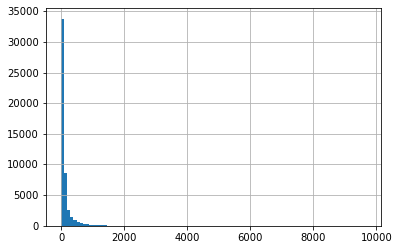

In [260]:
data['Number of Reviews'].hist(bins=100)
#Практически все значения лежат в промежутке от 0 до 2000. Подавляющее большинство из них <=~250

## City

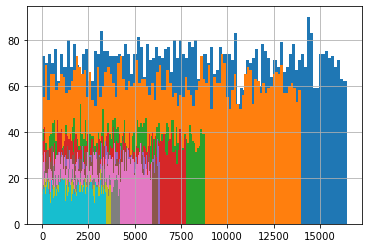

In [261]:
for x in (data['City'].value_counts())[0:10].index:
    data['Ranking'][data['City'] == x].hist(bins=100)
plt.show()
#Из-за того, что в больших городах больше ресторанов, имеем смещение

In [262]:
#Этот нечисловой показатель очень удобно будет преоразовать в dummy-переменные, но прежде создадим новый показатель -
#количество ресторанов в городе (Restaurants in City)
rests = pd.DataFrame(data.groupby('City').count()['Restaurant_id'])
rests.columns = ['Restaurants in City']
data = data.merge(rests, on = 'City', how = 'left')

#Переводим в dummy 
data = pd.get_dummies(data, columns=[ 'City',], dummy_na=True)

##  Cuisine Style

In [263]:
#Избавимся от пропусков добалением неизвестного параметра и создадаим новый признак - количество кухонь в ресторане (Cuisine Style Count)

data['Cuisine Style'] = data['Cuisine Style'].apply(clean_name)

data['Cuisine Style Count']=data['Cuisine Style'].apply(lambda x: len(x))

<AxesSubplot:>

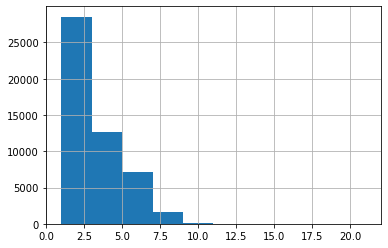

In [264]:
data['Cuisine Style Count'].hist(bins=10)
#В большинстве ресторанов не более 5 кухонь

## Price range

In [265]:
#Преобразуем показатель в числовой и заполним пропуски наиболее часто встречающимся вариантом 
data['Price Range'].mode()

0    $$ - $$$
dtype: object

In [269]:
data['Price Range'] = data['Price Range'].fillna('$$ - $$$')

    
data['Price']=data['Price Range'].apply(get_price)

<AxesSubplot:>

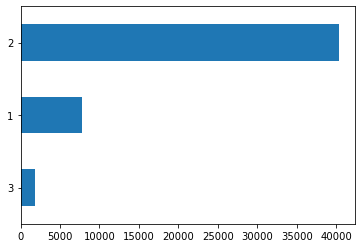

In [277]:
data['Price'].value_counts(ascending=True).plot(kind='barh')
#График более наглядно показывает, что средний чек в представленных ресторанх чаще всего составляет среднее значение

## Reviews

In [272]:
#Из этого параметра извлечём даты отзывов, чтобы создать новый признак - разинцу во днях между отзывами (day_space)

data['Reviews'] = data['Reviews'].fillna('')
pattern = re.compile("\d+\/\d+\/\d+")
data['Date_of_Reviews'] = data['Reviews'].apply(pattern.findall)

    
data['Date1']=data['Date_of_Reviews'].apply(date1)
data['Date2']=data['Date_of_Reviews'].apply(date2)

data['Date2'] = data['Date2'].apply(lambda x: str(x).replace('/', '-'))
data['Date1'] = data['Date1'].apply(lambda x: str(x).replace('/', '-'))
data['Date2']= pd.to_datetime(data['Date2'], errors='ignore')
data['Date1']= pd.to_datetime(data['Date1'], errors='ignore')

data['day_space'] = (data['Date1']-data['Date2']).dt.days

<AxesSubplot:>

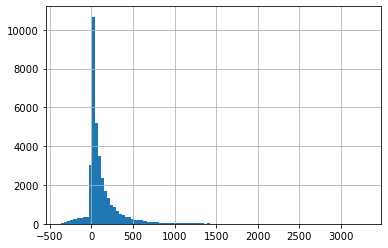

In [275]:
data['day_space'].hist(bins=100)
#В большинстве случаев разница по времени между отзывами небольшая, но также много случаев, когда между отзывами прошло несколько месяцев и более

## Capital

In [281]:
#Это показатель административного значения города. Преобразуем его в числовой показатель.
data['Capital'] = data['Capital'].apply(lambda x: 2 if x == 'primary'
                                       else 1 if x == 'admin'
                                       else 0)

<AxesSubplot:>

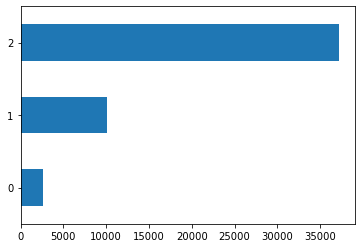

In [282]:
data['Capital'].value_counts(ascending=True).plot(kind='barh')
#Больше половины представленных городв - административные центры или столицы

## Матрица корреляций признаков

<AxesSubplot:>

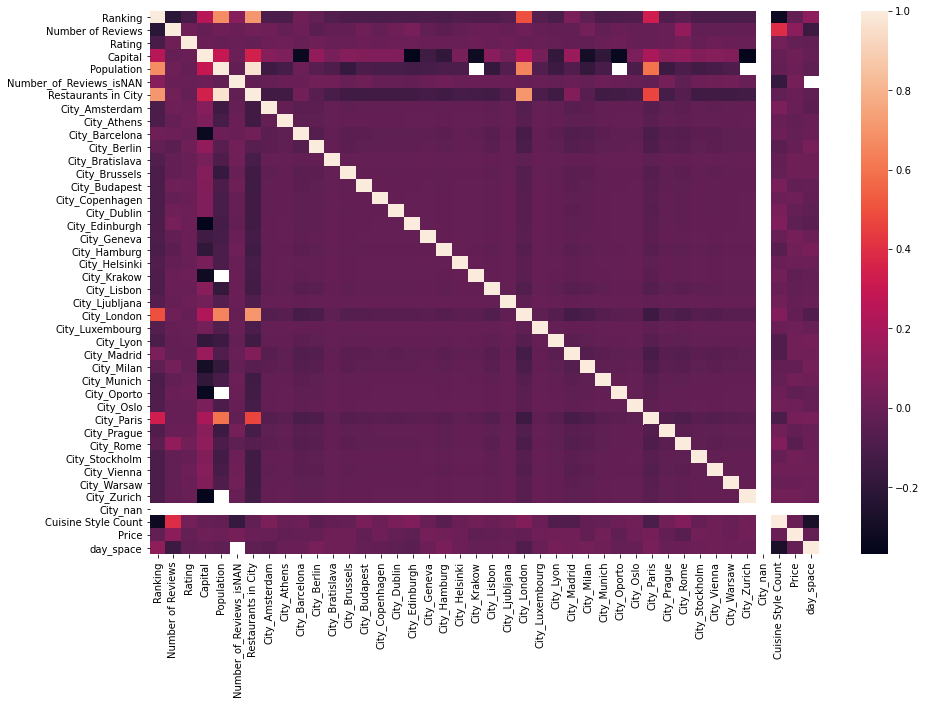

In [283]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(),)

# ML

In [284]:
object_columns = [s for s in data.columns if data[s].dtypes == 'object']

data.drop(object_columns, axis = 1, inplace=True)
data.drop(['Date1', 'Date2'], axis = 1, inplace=True)

In [285]:
df_preproc = data
df_preproc = df_preproc.fillna(0)
df_preproc.sample(10)

,Ranking,Number of Reviews,sample,Rating,Capital,Population,Number_of_Reviews_isNAN,Restaurants in City,City_Amsterdam,City_Athens,...,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan,Cuisine Style Count,Price,day_space
28375,7141.0,26.0,1,3.0,1,4588000.0,0,3395,0,0,...,0,0,0,0,0,0,0,1,1,29.0
41841,13829.0,3.0,1,3.5,2,10979000.0,0,7193,0,0,...,0,0,0,0,0,0,0,3,2,78.0
1632,192.0,324.0,0,0.0,1,1351562.0,0,2694,0,0,...,0,0,0,0,0,0,0,7,2,161.0
8344,1138.0,24.0,0,0.0,0,0.0,0,554,0,0,...,0,0,0,0,0,0,0,2,1,260.0
13824,2482.0,413.0,1,4.0,2,10979000.0,0,7193,0,0,...,0,0,0,0,0,0,0,4,2,17.0
17327,5511.0,147.0,1,3.5,2,11020000.0,0,6108,0,0,...,0,0,0,0,0,0,0,3,2,179.0
15021,7935.0,98.0,1,4.0,2,11020000.0,0,6108,0,0,...,0,0,0,0,0,0,0,1,2,14.0
40381,439.0,10.0,1,4.5,2,122273.0,0,263,0,0,...,0,0,0,0,0,0,0,1,2,0.0
37512,7575.0,91.0,1,4.0,2,10979000.0,0,7193,0,0,...,0,0,0,0,0,0,0,4,2,109.0
6991,41.0,773.0,0,0.0,2,1752286.0,0,1021,0,0,...,0,0,0,0,0,0,0,5,2,1.0


In [286]:
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

In [287]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [288]:
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 42), (40000, 42), (40000, 41), (32000, 41), (8000, 41))

In [289]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [290]:
# Создаём модель
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [291]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.4s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


In [292]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.20758937500000002


<AxesSubplot:>

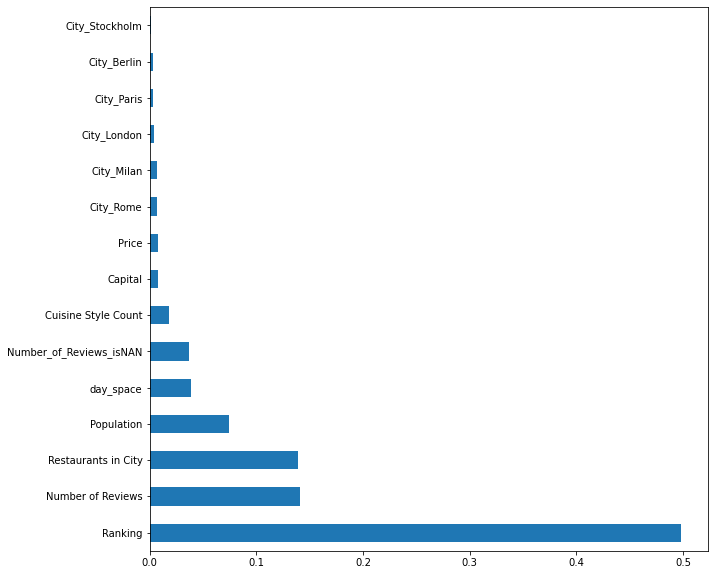

In [293]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')